In [106]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K

In [107]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [134]:
file_path = '../data/WHO-COVID-19-global-data.csv'
date_column='Date_reported'
target_column='New_deaths'
id_column='WHO_region'
df = pd.read_csv(file_path)[[date_column, target_column, id_column]]
df[date_column] = pd.to_datetime(df[date_column])
df = df.groupby([date_column])[target_column].sum().reset_index()
df[id_column] = 'A'
unique_dates = df[date_column].unique()
um_countries_regions = 1
df.head()

,Date_reported,New_deaths,WHO_region
0,2020-01-03,0,A
1,2020-01-04,0,A
2,2020-01-05,3,A
3,2020-01-06,0,A
4,2020-01-07,0,A


In [135]:
pivot_df = df.pivot_table(index=date_column, columns=id_column, values=target_column)

# Rename 'index' back to date_columneported
df.rename(columns={'index': date_column}, inplace=True)
df[date_column] = pd.to_datetime(df[date_column])
unique_dates = df[date_column].unique()
# df.set_index(date_column, inplace=True)
df.head()

,Date_reported,New_deaths,WHO_region
0,2020-01-03,0,A
1,2020-01-04,0,A
2,2020-01-05,3,A
3,2020-01-06,0,A
4,2020-01-07,0,A


In [136]:

unstaked_df = df.copy()
unstaked_df['id'] = unstaked_df['WHO_region']
unstaked_df.set_index(['id', 'Date_reported'], inplace=True)

# Dropping columns not needed for the analysis
unstaked_df.drop(['WHO_region'], axis=1, inplace=True)

# Converting data to float and unstacking
unstaked_df = unstaked_df.astype(float).unstack()
unstaked_df.columns = unstaked_df.columns.get_level_values(1)

# Displaying the shape and head of the updated DataFrame
print(unstaked_df.shape)
unstaked_df.iloc[:, : 15].head()



(1, 1420)


Date_reported,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17
id,,,,,,,,,,,,,,,
A,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [137]:
### UTILITY FUNCTIONS FOR FEATURE ENGINEERING ###

sequence_length = 12

# um_countries_regions = df.shape[0] 

def get_timespan(df, today, days):    
    df = df[pd.date_range(today - timedelta(days=days), 
            periods=days, freq='D')] # day - n_days <= dates < day    
    return df

def create_features(df, today, seq_len):
    
    all_sequence = get_timespan(df, today, seq_len).values
    
    group_store = all_sequence.reshape((-1, um_countries_regions, seq_len))
    
    store_corr = np.stack([np.corrcoef(i) for i in group_store], axis=0)
    
    store_features = np.stack([
              group_store.mean(axis=2),
              group_store[:,:,int(sequence_length/2):].mean(axis=2),
              group_store.std(axis=2),
              group_store[:,:,int(sequence_length/2):].std(axis=2),
              skew(group_store, axis=2),
              kurtosis(group_store, axis=2),
              np.apply_along_axis(lambda x: np.polyfit(np.arange(0, sequence_length), x, 1)[0], 2, group_store)
            ], axis=1)
    
    group_store = np.transpose(group_store, (0,2,1))
    store_features = np.transpose(store_features, (0,2,1))
    
    return group_store, store_corr, store_features

def create_label(df, today):
    
    y = df[today].values
    
    return y.reshape((-1, um_countries_regions))

In [138]:
### DEFINE TRAIN, VALID, TEST DATES ###

train_date = unique_dates[0]
valid_date = unique_dates[-(len(unique_dates)//2-1)]
test_date = unique_dates[-len(unique_dates)//4]

In [139]:
X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(train_date+timedelta(days=sequence_length), valid_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_train_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_train_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_train_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_train = np.concatenate(y, axis=0).astype('float16')

print(X_train_seq.shape, X_train_cor.shape, X_train_feat.shape, y_train.shape)

100%|██████████| 700/700 [00:02<00:00, 330.22it/s]

(700, 12, 1) (700,) (700, 1, 7) (700, 1)


In [140]:
### CREATE VALID FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(valid_date+timedelta(days=sequence_length), test_date)):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_valid_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_valid_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_valid_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_valid = np.concatenate(y, axis=0).astype('float16')

print(X_valid_seq.shape, X_valid_cor.shape, X_valid_feat.shape, y_valid.shape)


100%|██████████| 343/343 [00:01<00:00, 339.38it/s]

(343, 12, 1) (343,) (343, 1, 7) (343, 1)


In [141]:
### CREATE TEST FEATURES ###

X_seq, X_cor, X_feat, y = [], [], [], []

for d in tqdm(pd.date_range(test_date+timedelta(days=sequence_length), unique_dates[-1])):
    seq_, corr_, feat_ = create_features(unstaked_df, d, sequence_length)
    y_ = create_label(unstaked_df, d)
    X_seq.append(seq_), X_cor.append(corr_), X_feat.append(feat_), y.append(y_)
    
X_test_seq = np.concatenate(X_seq, axis=0).astype('float16')
X_test_cor = np.concatenate(X_cor, axis=0).astype('float16')
X_test_feat = np.concatenate(X_feat, axis=0).astype('float16')
y_test = np.concatenate(y, axis=0).astype('float16')

print(X_test_seq.shape, X_test_cor.shape, X_test_feat.shape, y_test.shape)

100%|██████████| 343/343 [00:01<00:00, 331.94it/s]

(343, 12, 1) (343,) (343, 1, 7) (343, 1)


In [142]:
### SCALE SEQUENCES ###

scaler_seq = StandardScaler()
scaler_feat = StandardScaler()

X_train_seq = scaler_seq.fit_transform(X_train_seq.reshape(-1,um_countries_regions)).reshape(X_train_seq.shape)
X_valid_seq = scaler_seq.transform(X_valid_seq.reshape(-1,um_countries_regions)).reshape(X_valid_seq.shape)
X_test_seq = scaler_seq.transform(X_test_seq.reshape(-1,um_countries_regions)).reshape(X_test_seq.shape)

y_train = scaler_seq.transform(y_train)
y_valid = scaler_seq.transform(y_valid)
y_test = scaler_seq.transform(y_test)

X_train_feat = scaler_feat.fit_transform(X_train_feat.reshape(-1,um_countries_regions)).reshape(X_train_feat.shape)
X_valid_feat = scaler_feat.transform(X_valid_feat.reshape(-1,um_countries_regions)).reshape(X_valid_feat.shape)
X_test_feat = scaler_feat.transform(X_test_feat.reshape(-1,um_countries_regions)).reshape(X_test_feat.shape)

In [143]:
X_train_lap = localpooling_filter(1 - np.abs(X_train_cor))
X_valid_lap = localpooling_filter(1 - np.abs(X_valid_cor))
X_test_lap = localpooling_filter(1 - np.abs(X_test_cor))

In [144]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model():
    
    set_seed(33)

    opt = Adam(lr=0.001)

    inp_seq = Input((sequence_length, um_countries_regions))
    inp_lap = Input((um_countries_regions, um_countries_regions))
    inp_feat = Input((um_countries_regions, X_train_feat.shape[-1]))

    x = GraphConv(32, activation='relu')([inp_feat, inp_lap])
    x = GraphConv(16, activation='relu')([x, inp_lap])
    x = Flatten()(x)

    xx = LSTM(128, activation='relu', return_sequences=True)(inp_seq)
    xx = LSTM(32, activation='relu')(xx)

    x = Concatenate()([x,xx])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(1)(x)

    model = Model([inp_seq, inp_lap, inp_feat], out)
    model.compile(optimizer=opt, loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [145]:
model = get_model()
model.summary() 

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_75 (InputLayer)       [(None, 1, 7)]               0         []                            
                                                                                                  
 input_74 (InputLayer)       [(None, 1, 1)]               0         []                            
                                                                                                  
 graph_conv_48 (GraphConv)   (None, 1, 32)                256       ['input_75[0][0]',            
                                                                     'input_74[0][0]']            
                                                                                                  
 input_73 (InputLayer)       [(None, 12, 1)]              0         []                     

In [146]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###

pred_valid_all = np.zeros(y_valid.shape)
pred_test_all = np.zeros(y_test.shape)

for store in range(um_countries_regions):

    print('-------', 'store', store, '-------')
    
    es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

    model = get_model()
    model.fit([X_train_seq, X_train_lap, X_train_feat], y_train[:,store], epochs=100, batch_size=256, 
              validation_data=([X_valid_seq, X_valid_lap, X_valid_feat], y_test[:,store]), callbacks=[es], verbose=2)

    pred_valid_all[:,store] = model.predict([X_valid_seq, X_valid_lap, X_valid_feat]).ravel()
    pred_test_all[:,store] = model.predict([X_test_seq, X_test_lap, X_test_feat]).ravel()


pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
reverse_valid = scaler_seq.inverse_transform(y_valid)
pred_test_all = scaler_seq.inverse_transform(pred_test_all)
reverse_test = scaler_seq.inverse_transform(y_test)

------- store 0 -------
Epoch 1/100


ValueError: in user code:

    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 1 of layer "model_25" is incompatible with the layer: expected shape=(None, 1, 1), found shape=(None, 700)


In [127]:
### RMSE ON TEST DATA ###

error = {}

for store in range(7):
    
    error[store] = np.sqrt(mean_squared_error(reverse_test[:,store], pred_test_all[:,store]))

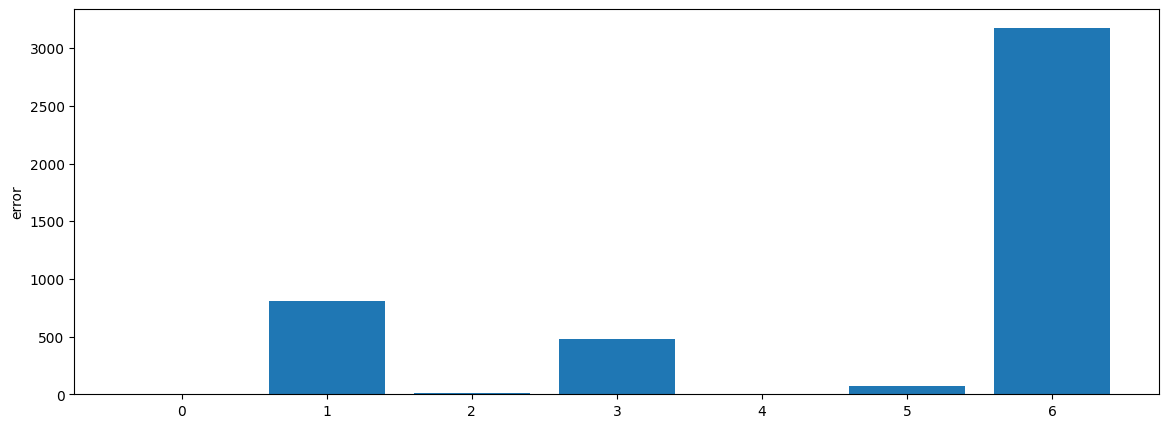

In [128]:


### PLOT RMSE ###

plt.figure(figsize=(14,5))
plt.bar(range(7), error.values())
plt.xticks(range(7), [str(s) for s in range(7)])
plt.ylabel('error')
np.set_printoptions(False)



In [129]:
def plot_predictions(y_true, y_pred, store, item):
    
    y_true = y_true.reshape(1,-1,7)
    y_pred = y_pred.reshape(1,-1,7)
    
    plt.plot(y_true[item,:,store], label='true')
    plt.plot(y_pred[item,:,store], label='prediction')
    plt.title(f"store: {store} item: {item}"); plt.legend()
    plt.ylabel('sales'); plt.xlabel('date')

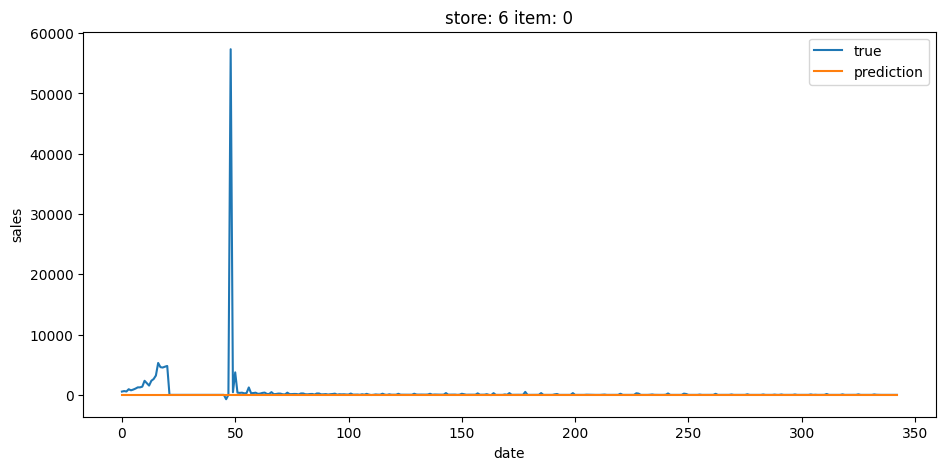

In [130]:


plt.figure(figsize=(11,5))
plot_predictions(reverse_test, pred_test_all, 6,0)

